# Experimental Quantum Generative Adversarial Networks for Image Generation
A paper by Huang et al.

In [9]:
import jax
import jax.random as jr
import optax
import matplotlib.pyplot as plt
import pennylane as qml

from quantumgan.batch import BatchGAN
from quantumgan.train import train_gan
import quantumgan.datasets as datasets

key = jr.PRNGKey(100)
features_dim = 4
batch_size = 1

## Batch GAN

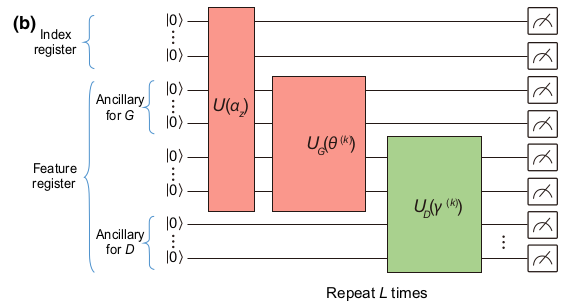

### Dataset

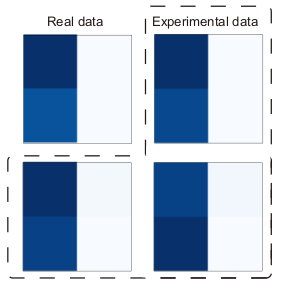

$$\mathbf{x}\in\mathbb{R}^{2\times 2}$$
$$\mathbf{x}_{00}\sim\text{unif}(0.4,0.6)$$
$$\mathbf{x}_{10}=1-\mathbf{x}_{0i}$$
$$\mathbf{x}_{01,11}=0$$

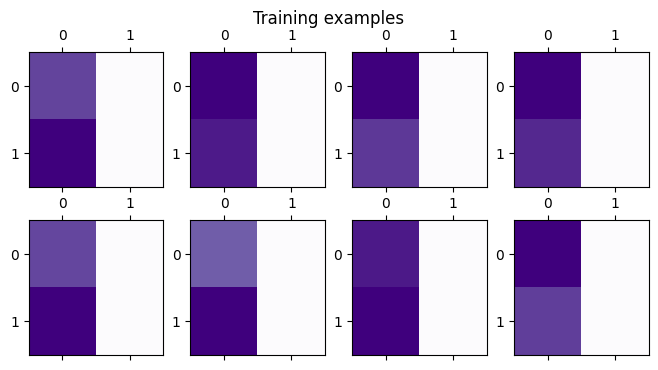

In [10]:
def grid_imshow(title, rows, cols, w, h, grid):
    fig, ax = plt.subplots(rows, cols, figsize=(2*cols,2*rows))
    fig.suptitle(title)
    for row in range(rows):
        for col in range(cols):
            ax[row,col].matshow(grid[row,col].reshape((w,h)), cmap='Purples')
    return fig

key, data_key = jr.split(key)
train_data = datasets.generate_grayscale_bar(data_key, 5000).reshape(
    -1, batch_size, 4
)

_ = grid_imshow('Training examples', 2, 4, 2, 2, train_data[0:8].reshape((2,4,2,2)))
plt.show()
plt.close()

In [11]:
key, params_key = jr.split(key)

gen_params, dis_params = BatchGAN.init_params(
    params_key,
    features_dim,
    gen_layers=3,
    gen_ancillary=1,
    dis_layers=4,
    dis_ancillary=1,
)


gan = BatchGAN(
    features_dim,
    1,
    gen_params,
    dis_params,
)

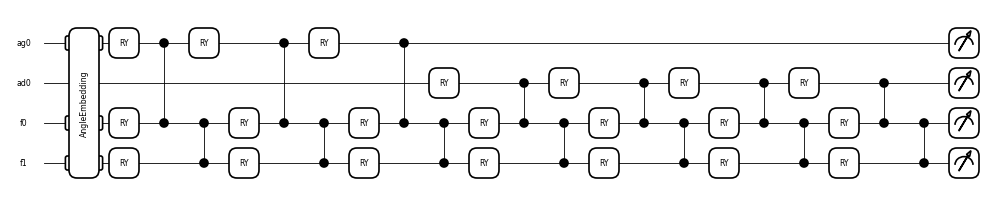

In [12]:
latent = gan.random_latent(key, 1)[0]
fig, ax = qml.draw_mpl(gan._qnode_train_fake)(gan.gen_params, gan.dis_params, latent)
fig.set_dpi(40)
plt.show()
plt.close()

In [13]:
key, train_key = jr.split(key)

gen_optimizer = optax.sgd(0.05)
dis_optimizer = optax.sgd(0.001)

train_result = train_gan(
    train_key,
    gan,
    gen_optimizer,
    dis_optimizer,
    train_data,
    show_progress=True,
)

latent = gan.random_latent(key, 1)
# Final checkpoint
gan = train_result.checkpoints[-1][1]

  0%|                                                                      | 0/5000 [00:00<?, ?it/s]/home/sjs/.cache/pypoetry/virtualenvs/quantumgan-UdhKpwOe-py3.10/lib/python3.10/site-packages/autoray/autoray.py:981: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(dtype, **kwargs)
100%|████████████████████████████████████████| 5000/5000 [00:06<00:00, 779.64it/s, g=0.684, d=0.694]


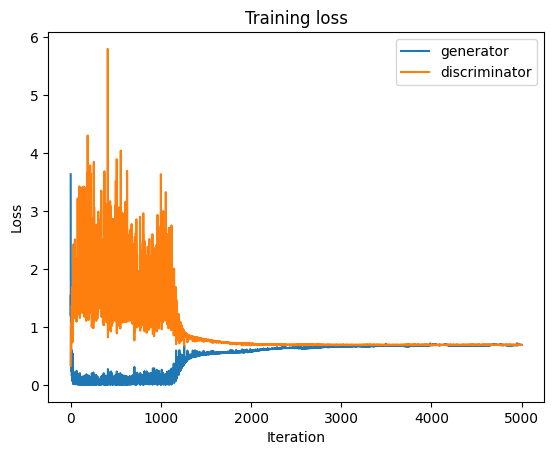

In [14]:
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(range(5000), train_result.g_loss_history, label='generator')
plt.plot(range(5000), train_result.d_loss_history, label='discriminator')
plt.legend()
plt.show()
plt.close()

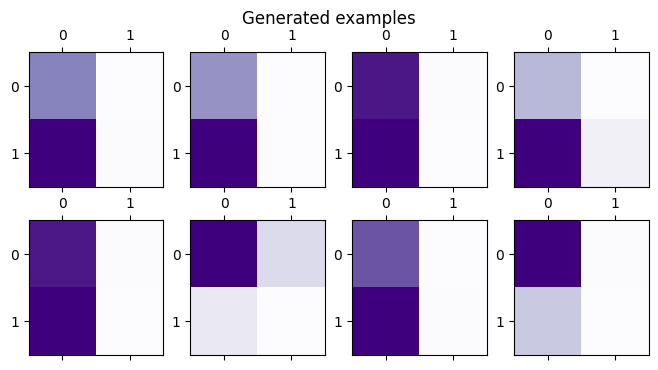

In [15]:
gen_key, key = jax.random.split(key)
d = gan.generate(gan.random_latent(gen_key, 8)).reshape(2,4,2,2)
_ = grid_imshow('Generated examples', 2, 4, 2, 2, d)
plt.show()
plt.close()